# Previsão de Energia Ativa de Usina Solar

Importando as bibliotecas a serem utilizadas

In [156]:
import pandas as pd
import matplotlib .pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

Fazendo a leitura do dado

In [157]:
df = pd.read_csv('data.csv', delimiter=',', parse_dates=['Instante'])

Plotando Variável Energia Ativa Kwh 

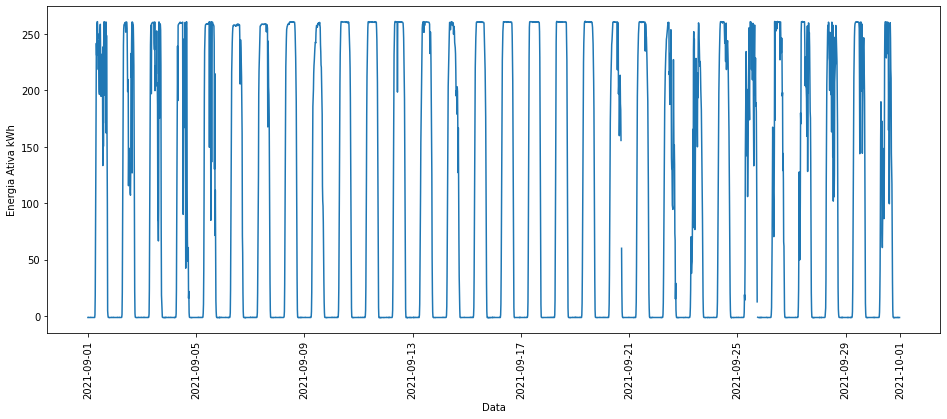

In [158]:
plt.figure(figsize=(16,6))
plt.plot(df['Instante'], df['Energia Ativa kWh'])
plt.xticks(rotation=90)
plt.xlabel('Data')
plt.ylabel('Energia Ativa kWh')
plt.show()


Observando dados nulos

In [159]:
df_dados = df.filter(["Instante", "Energia Ativa kWh"])
df_dados = df_dados.set_index('Instante')

df_dados[df_dados['Energia Ativa kWh'].isna() == True]

,Energia Ativa kWh
Instante,
2021-09-16 12:45:00,NaN
2021-09-20 17:00:00,NaN
2021-09-21 10:45:00,NaN
2021-09-21 11:30:00,NaN
2021-09-25 17:45:00,NaN
2021-09-29 02:00:00,NaN
2021-09-29 04:30:00,NaN


### Interpolando Dados

Já que os dados são uma série temporal com apenas poucos horários não sequenciados faltando, podemos interpolar usando pandas

In [160]:
df_dados_interpolados = df_dados.interpolate()
df_dados.interpolate()[df_dados['Energia Ativa kWh'].isna() == True]


,Energia Ativa kWh
Instante,
2021-09-16 12:45:00,260.505
2021-09-20 17:00:00,107.835
2021-09-21 10:45:00,260.295
2021-09-21 11:30:00,260.610
2021-09-25 17:45:00,5.775
2021-09-29 02:00:00,-1.260
2021-09-29 04:30:00,-1.260


<AxesSubplot:xlabel='Instante'>

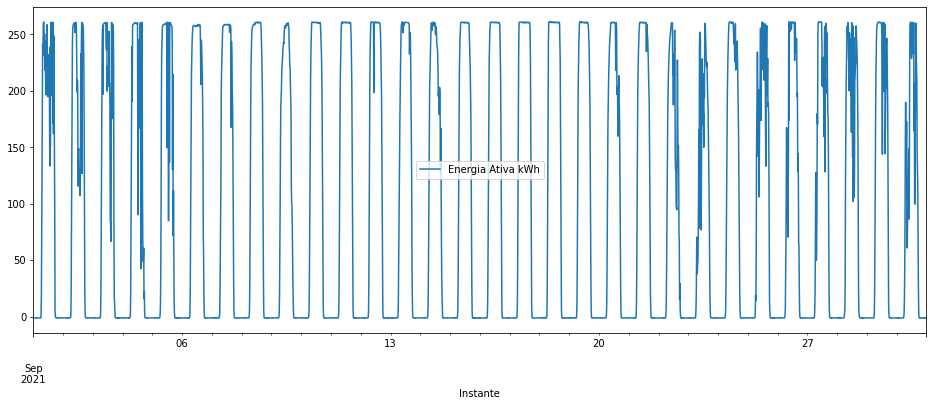

In [161]:
df_dados_interpolados.plot(figsize=(16,6))

### Decompondo dados

Podemos notar que há um sazonalidade diária bem definida, com poucos ruídos nessa tendência.

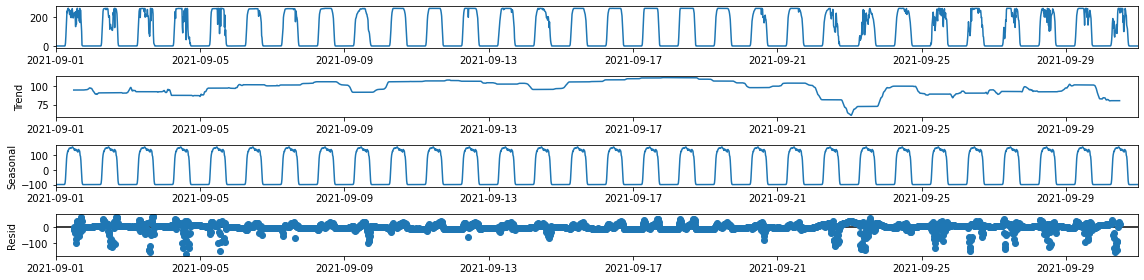

In [162]:
result_decompose = seasonal_decompose(df_dados_interpolados, model='additive', period=4*24)
fig = result_decompose.plot()
fig.set_size_inches((16, 4))
fig.tight_layout()
plt.show()

### Definindo parâmentros do modelo SARIMA

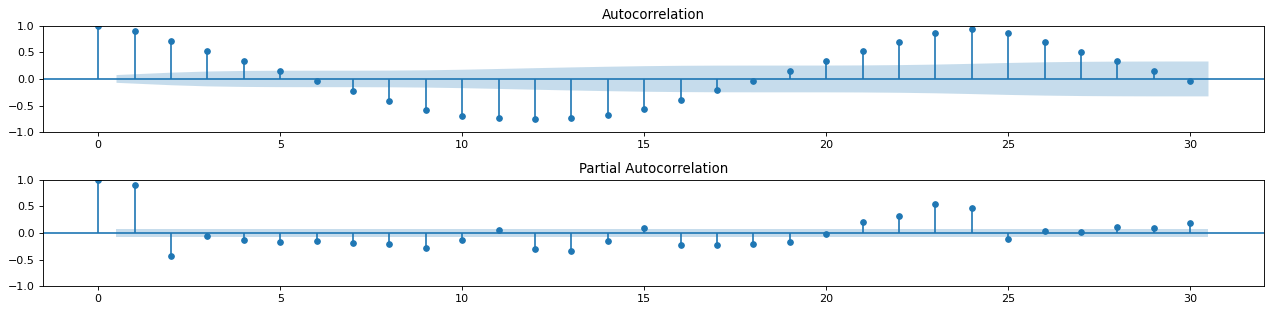

In [163]:
#Transformando os dados em médias horárias

df_horario = df_dados_interpolados.resample('H').mean()

fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(16,4), dpi= 80)
plot_acf(df_horario.values.tolist(), ax=ax1, lags=30)
plot_pacf(df_horario.values.tolist(), ax=ax2, lags=30)
fig.tight_layout()
plt.show()

In [148]:
import pmdarima as pm
pm.auto_arima(df_horario, start_p=1, start_q=1,
                            test='adf',
                            max_p=7, max_q=7, m=7,
                            start_P=0, seasonal=True,
                            max_d=7, max_D=7, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True, approximation=True, max_order=10)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=7571.818, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=8870.490, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=7693.358, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=7995.538, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=9265.562, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=7576.056, Time=0.15 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=7540.382, Time=0.62 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=7576.247, Time=0.36 sec
 ARIMA(1,0,1)(2,0,1)[7] intercept   : AIC=7462.236, Time=1.15 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=7464.925, Time=0.88 sec
 ARIMA(1,0,1)(2,0,2)[7] intercept   : AIC=7452.887, Time=1.53 sec
 ARIMA(1,0,1)(1,0,2)[7] intercept   : AIC=7468.694, Time=1.06 sec
 ARIMA(0,0,1)(2,0,2)[7] intercept   : AIC=7911.862, Time=1.54 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=7533.720, Time=1.16 sec
 ARIMA(2,0,1)(2,0,2)[7] intercept

ARIMA(order=(1, 0, 5), scoring_args={}, seasonal_order=(2, 0, 2, 7),
      suppress_warnings=True)

### Calculado a previsão com o modelo gerado

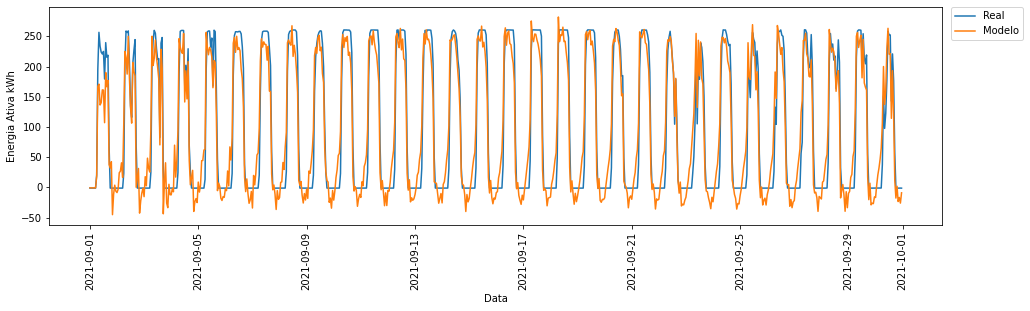

In [168]:
modelo = SARIMAX(df_horario.values, order=(1,0,5), seasonal_order = (2,0,2,7))
resultado = modelo.fit()

previsao = resultado.predict(start=1, end=len(df_horario.values))

previsao_series = pd.Series(previsao, index=df_horario.index)

plt.figure(figsize=(16,4))
plt.plot(df_horario, label='Real')
plt.plot(previsao_series, label='Modelo')
plt.xticks(rotation=90)
plt.legend(title_fontsize=30, loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
plt.xlabel('Data')
plt.ylabel('Energia Ativa kWh')
plt.show()
